In [1]:
import tike
import dxchange
import scipy
import numpy as np
import matplotlib.pyplot as plt
from tike.constants import *

# Setup Experiment

## Probe

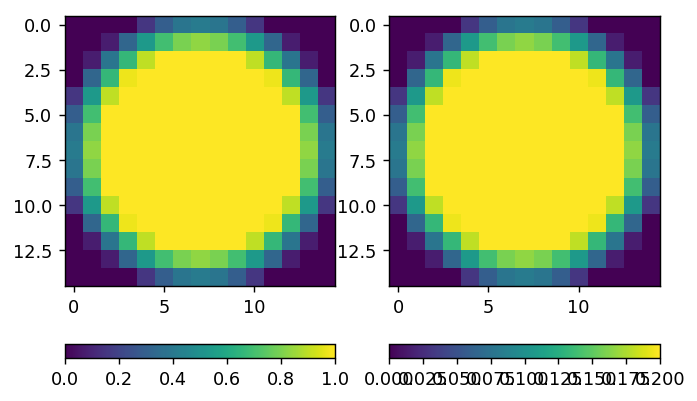

0j (0.980067+0.198669j)


In [2]:
# Create a probe.
pw = 15 # probe width
energy = 5 # keV probe energy
weights = tike.ptycho.gaussian(pw, rin=0.8, rout=1.0)
probe = weights * np.exp(1j * weights * 0.2)
tike.plot_phase(probe)

## Object

In [3]:
# Load a 3D object.
beta = dxchange.read_tiff('test-beta-128.tiff')[0:2 * pw, :, :]
delta = dxchange.read_tiff('test-delta-128.tiff')[0:2 * pw, :, :]
beta.shape

INFO:dxchange.reader:Data succesfully imported: /home/beams0/B242827/Documents/tike/dev/test-beta-128.tiff
INFO:dxchange.reader:Data succesfully imported: /home/beams0/B242827/Documents/tike/dev/test-delta-128.tiff


(30, 128, 128)

In [4]:
np.min(beta), np.max(beta)

(-1.655023e-20, 2.7094511e-05)

In [5]:
np.min(delta), np.max(delta)

(0.0, 0.00013467284)

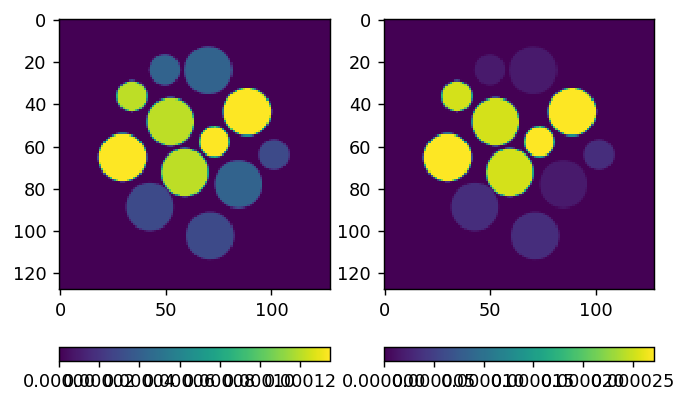

In [6]:
# Assemble the object.
voxelsize = 1e-7
obj = np.empty(beta.shape, dtype=complex)
obj.real = delta
obj.imag = beta
tike.plot_complex(obj[0])

## Trajectory

In [7]:
N_ANGLE = int(np.pi / 2 * obj.shape[2])
theta = np.linspace(0, np.pi, N_ANGLE, endpoint=False)
theta.shape

(201,)

In [8]:
v, h = np.meshgrid(np.arange(0, obj.shape[0]-pw, pw//2,),
                   np.arange(0, obj.shape[2]-pw, pw//2,),
                   indexing='ij')
print(h.shape)
h = h.flatten()
v = v.flatten()
h

(3, 17)


array([  0,   7,  14,  21,  28,  35,  42,  49,  56,  63,  70,  77,  84,
        91,  98, 105, 112,   0,   7,  14,  21,  28,  35,  42,  49,  56,
        63,  70,  77,  84,  91,  98, 105, 112,   0,   7,  14,  21,  28,
        35,  42,  49,  56,  63,  70,  77,  84,  91,  98, 105, 112])

# Simulate data

In [9]:
line_integrals = tike.tomo.forward(obj=obj, theta=theta) * voxelsize
line_integrals.shape

INFO:tike.tomo:forward 491,520 element grid
INFO:tike.tomo:forward 771,840 rays


(201, 30, 128)

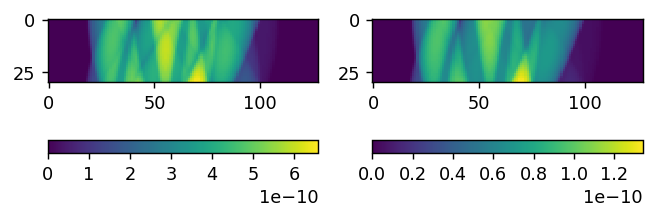

In [10]:
tike.plot_complex(line_integrals[0])

In [11]:
psi = np.exp(1j * wavenumber(energy) * line_integrals)

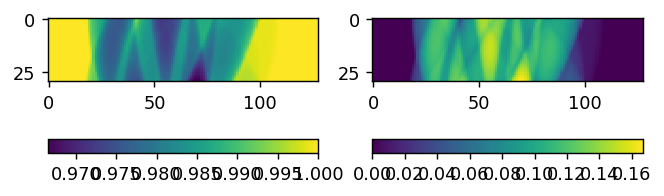

(0.953120178139+0.160543372645j) (1+0j)


In [12]:
tike.plot_phase(psi[0])

In [13]:
data = tike.ptycho.simulate(data_shape=np.ones(2, dtype=int) * pw * 3,
                            probe=probe, v=v, h=h,
                            psi=psi)
data.shape

(10251, 45, 45)

In [14]:
dxchange.write_tiff(data.astype('float32'),
                    fname='data/detector-amplitude.tiff',
                    overwrite=True)

In [15]:
# data = dxchange.read_tiff(fname='data/detector-amplitude.tiff')

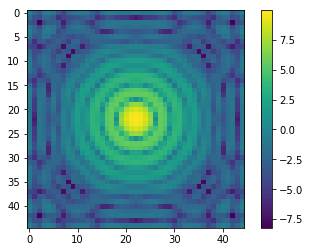

(1.336055045913337e-09, 21373.535233431674)

In [16]:
plt.imshow(np.fft.fftshift(np.log(data[16])))
plt.colorbar()
plt.show()
np.min(data), np.max(data)

# Reconstruct

In [18]:
# init = np.random.rand(*obj.shape, 2).view(complex)[..., 0]
recon = np.zeros(obj.shape, dtype=complex)
recon.shape

(30, 128, 128)

In [19]:
recon = tike.admm(obj=recon, voxelsize=voxelsize,
             data=data,
             probe=probe, theta=theta, v=v, h=h, energy=energy,
             niter=1,
             rho=0.5, gamma=0.25,
            )

INFO:tike.ptycho:grad on 20,758,275 element grid for 1 iterations
INFO:tike.tomo:forward 491,520 element grid
INFO:tike.tomo:forward 771,840 rays


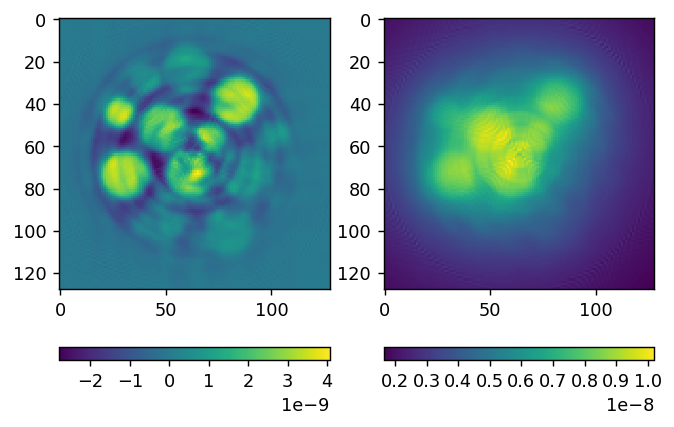

In [20]:
tike.plot_complex(recon[pw])